# Example of Clustering using local_stats

This notebook showcases the use of local_stats to analyse a typical diffraction
image. To start, we want to load an image. We'll use local_stats' Image class'
from_file method to load the image. The image we'll load ships with local_stats'
test suite, and is stored in the local_stats/tests/resources/ directory.

In [1]:
import os
os.chdir("C:\\Users\\wvx67826\\git\\local_stats\\")
from src.local_stats.image import Image

# Relative path from the docs/source/ directory to test/resources/.
path_to_tiff = "tests\\resources\\pixis-0.tiff"

# Loads the image as an instance of local_stats' Image class. This will give us
# access to lots of handy denoising and clustering functionality later.
image = Image.from_file(path_to_tiff)



We're going to need to render 2D numpy arrays as images a lot, so lets make a
convenience function for making these plots, with some nice defaults.

In [2]:
import matplotlib
from typing import Tuple

import numpy as np
%matplotlib inline
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


def plot_imshow(img: np.ndarray, figsize: Tuple[int] = (20, 20),
                cmap: str = 'jet', title="", **kwargs) -> None:
    """
    Imshow, but with the best colour scheme and a big size.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    picture = ax.imshow(img, cmap=cmap, **kwargs)
    fig.colorbar(picture, ax=ax)

    plt.title(title)

    fig.show()

Now that we've got that ready, lets plot the original image that we just loaded.
Note that the raw image data is stored as a numpy ndarray as an instance of
Image's image_array attribute.

<ipython-input-2-dcf38be93f7a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


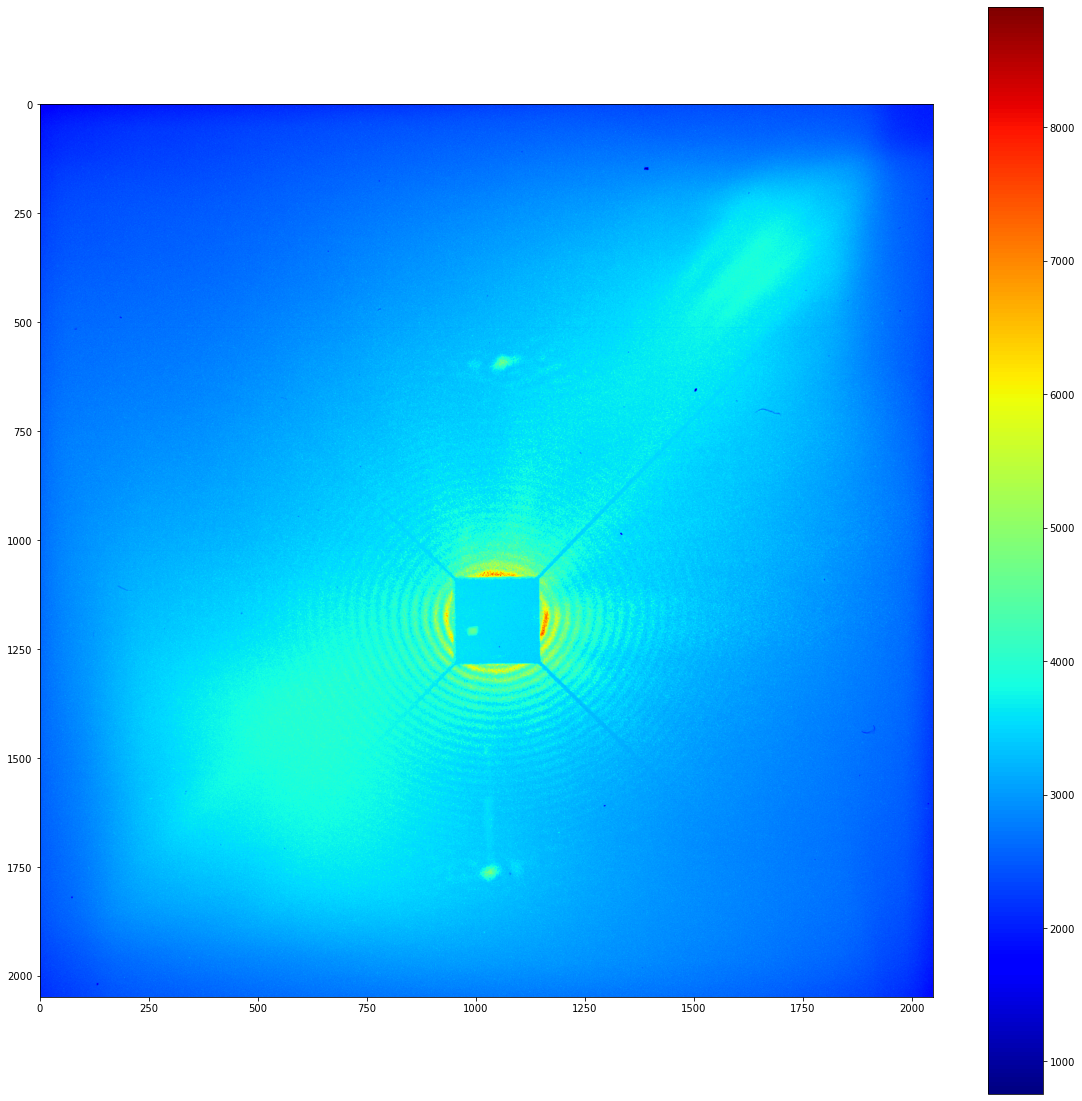

In [3]:
plot_imshow(image.image_array)

Well... that leaves a lot to be desired. One of the biggest problems with this
kind of data comes from the aging of the detector. These CCD cameras develop
regions where they pick up a large number of background counts that are
unrelated to the incident light.

The simplest way to get rid of these artefacts is to take a background image and
subtract it. Lets do that, and lets instantiate a local_stats image object at
the same time.

<ipython-input-2-dcf38be93f7a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


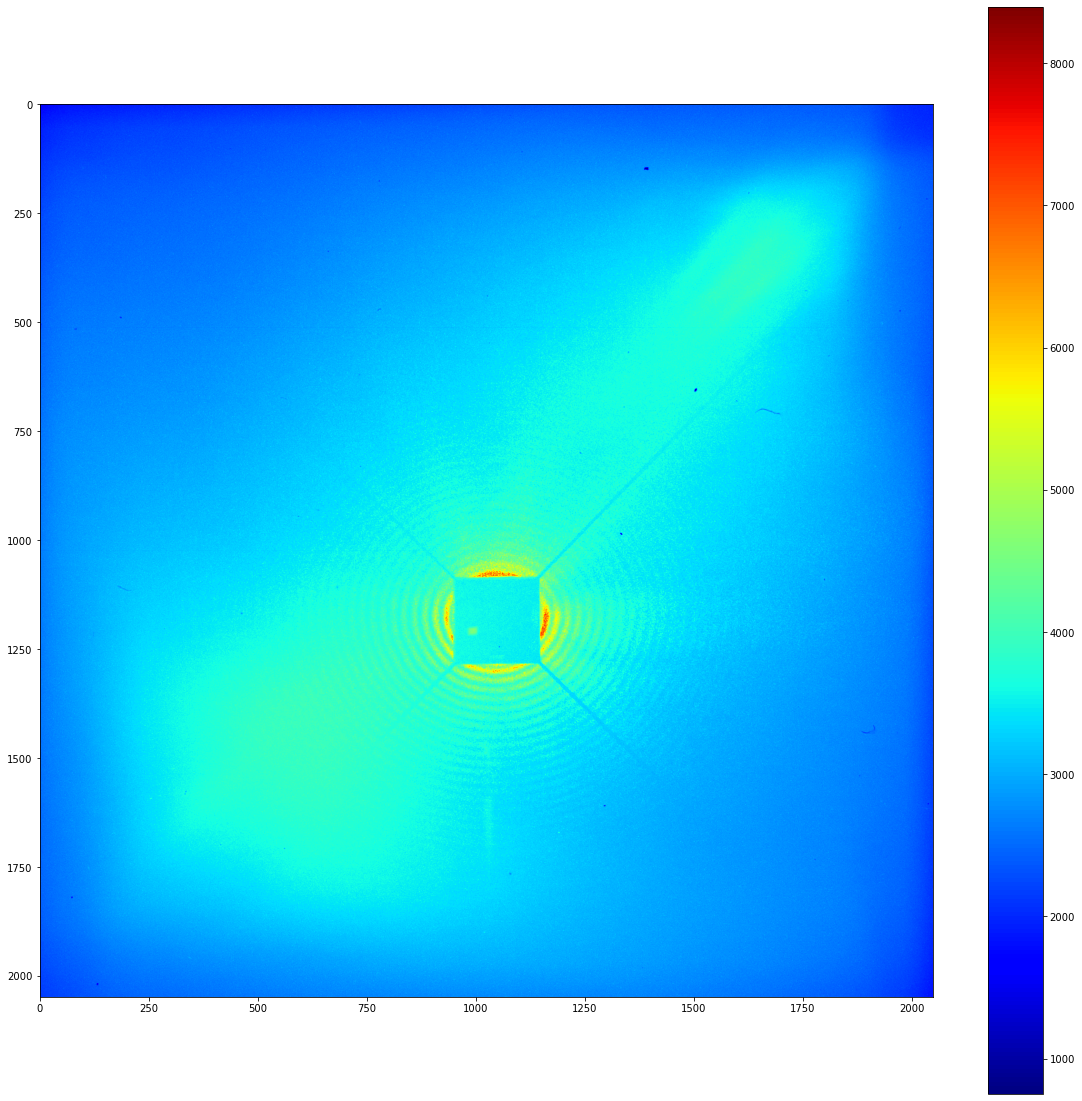

In [4]:
# Relative path to the background .tiff.
path_to_background_img = "tests/resources/background.tiff"
background_img = Image.from_file(path_to_background_img)

image.subtract_background(background_img)

# Lets see how our image looks now.

plot_imshow(background_img.image_array)

Okay, this looks a lot better, but stil contains a significant amount of noise.
To deal with this, lets use local_stats' wavelet denoising routine. This
requires, at the very least, knowledge of one parameter.

We need to know over what lengthscale (in units of pixels) signal
appears in our image. At a glance, I'd say that the peaks are around 20 pixels
wide.

It's worth appreciating that the pixel intensities in wavelet denoised images
lose their full physical meaning. So, before carrying out the wavelet denoising,
one should probably save a copy of the background subtracted image. This will
come in handy later.

Under the hood:

We can use this lengthscale to estimate what wavelet frequencies will represent
noise in the wavelet representation of the above image. These wavelets will be
preferentially culled compared to lower-frequency wavelets. Then, the image will
be wavelet transformed back to the original image-space after the decimation
procedure.

<ipython-input-2-dcf38be93f7a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


dtype('int32')

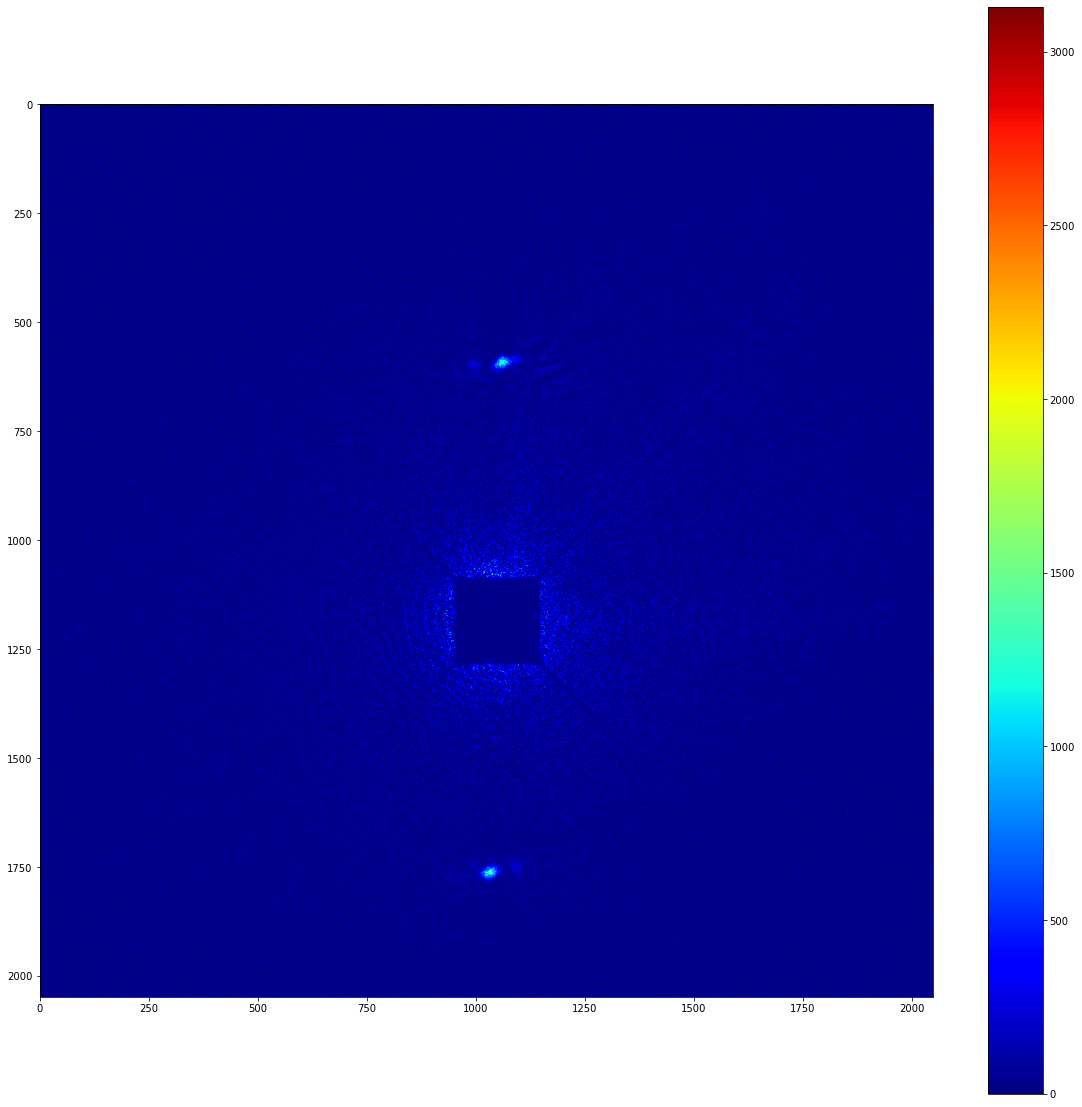

In [5]:
plot_imshow(image.image_array)
image.image_array.dtype

<ipython-input-2-dcf38be93f7a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


dtype('float64')

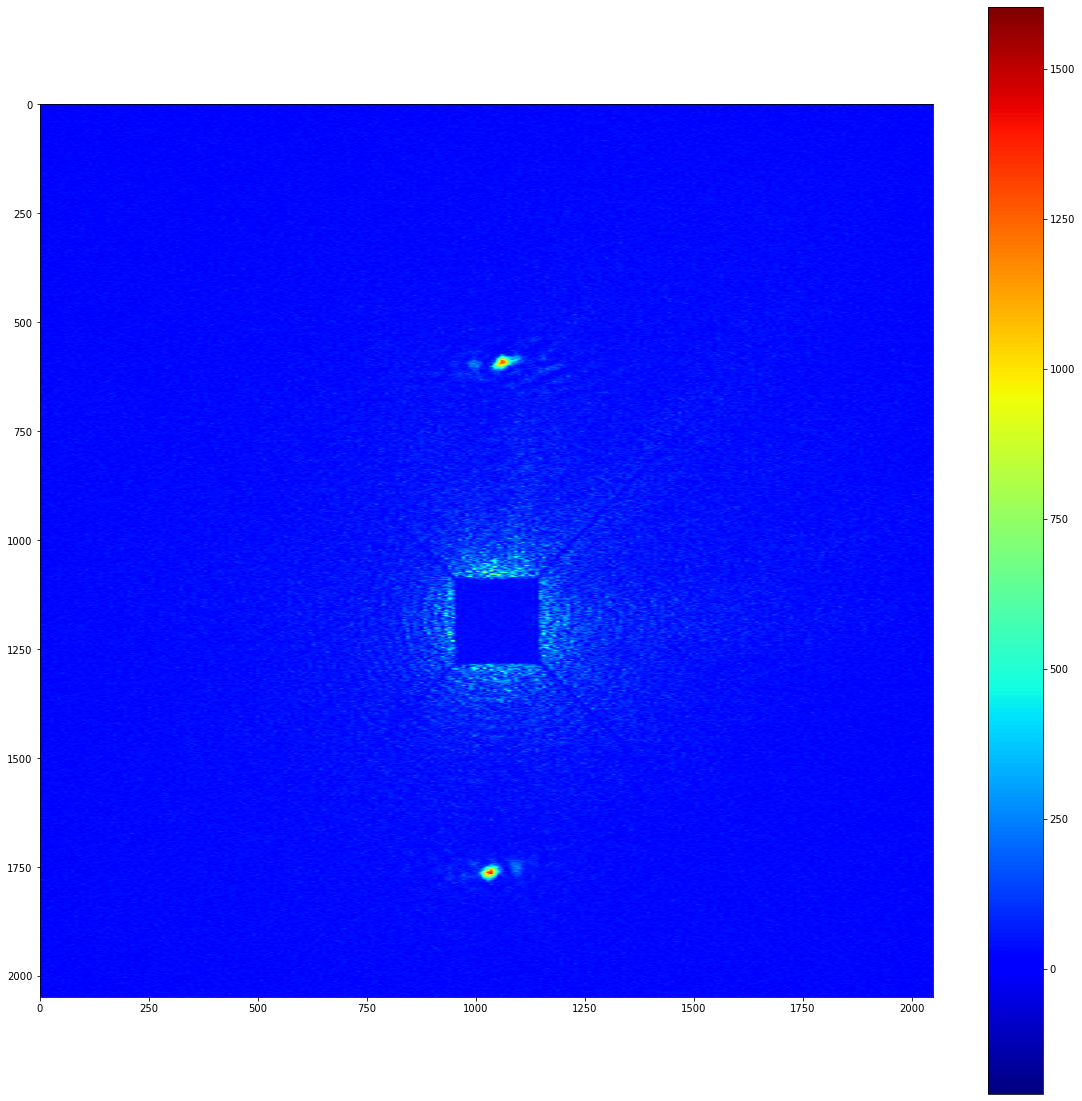

In [7]:
# Make a copy of the background subtracted image before doing any denoising.
bkg_subtracted_image_array = np.copy(image.image_array)

signal_length_scale = 20
image.wavelet_denoise()

plot_imshow(image.image_array)
image.image_array.dtype

Now we want to do some local stats on this image to work out which pixels are
statistically significant. To do this, we need to know the signal_length_scale
given above, as well as over what lengthscale (in units of pixels) the
background varies in the image. Here, background varies over around 100-200
pixels; smaller numbers will inevitably be more performant, so lets pick 100.

<ipython-input-2-dcf38be93f7a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


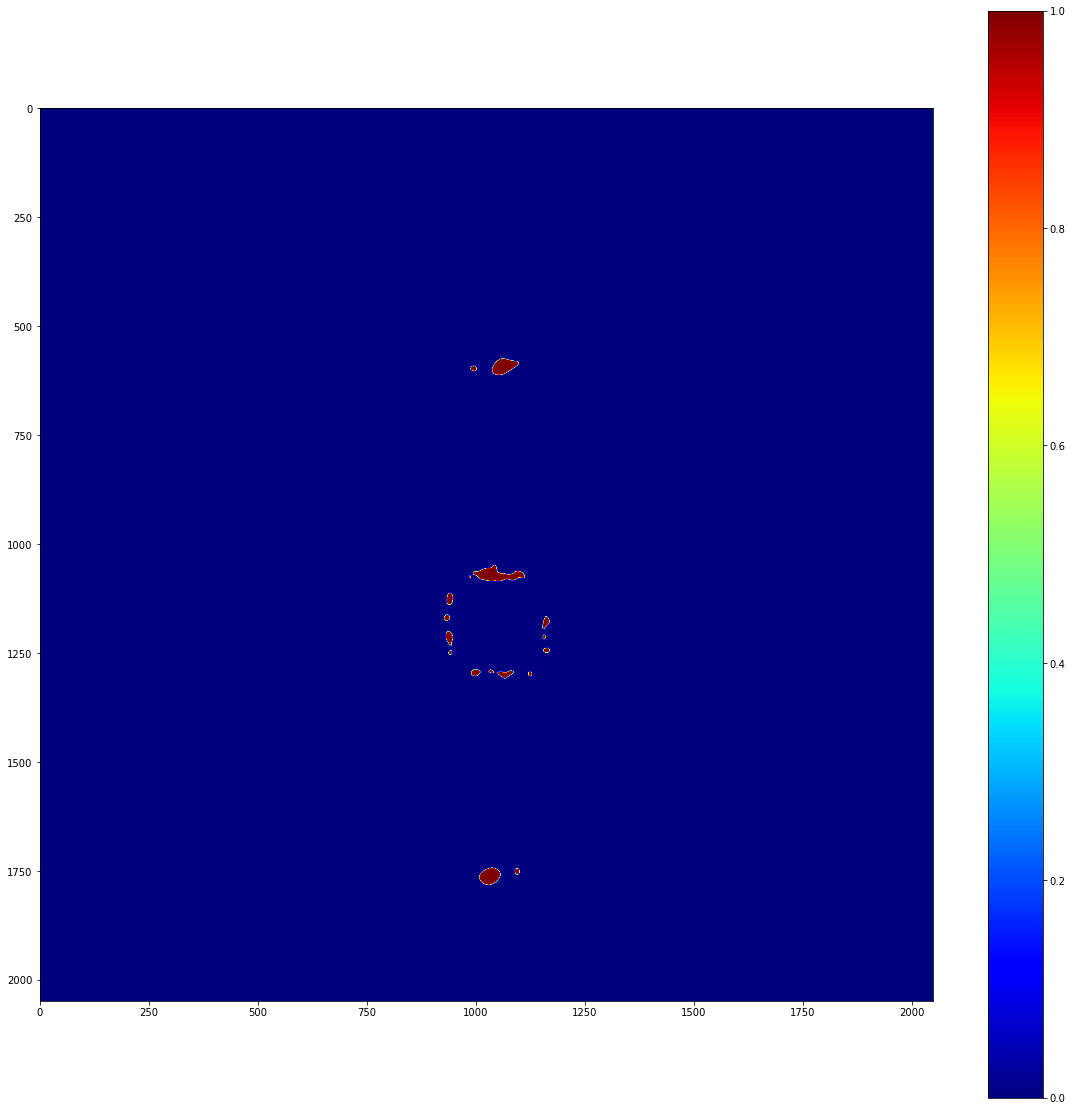

In [8]:
bkg_length_scale = 100

significant_pixels = image._significant_pixels(signal_length_scale,
                                               bkg_length_scale)

plot_imshow(significant_pixels)

This is reasonable, but there's a problem: the 0-count regions covered by the
beamstop in the experiment are affecting our local stats! To account for this,
we really need to use a mask when doing our statistical calculations. Lets make
a mask and run the significance map again.

In [21]:
open_mask = background_img.image_array > np.inf

# I'll just write down where I roughly worked out the beamstop finished.
# Calculated manually
beamstop_top = 1082
beamsotp_bottom = 1284
beamstop_left = 948
beamstop_right = 1145

# Internally, this mask will multiply an image array.
# So, 0 = masked, 1 = unmasked. 
mask = np.ones_like(background_img.image_array)
mask[(beamstop_top-bkg_length_scale):(beamsotp_bottom+bkg_length_scale),
     (beamstop_left-bkg_length_scale):(beamstop_right+bkg_length_scale)] = 0


significant_pixels = image._significant_pixels(
     signal_length_scale, bkg_length_scale, significance_mask=mask)

plot_imshow(significant_pixels)


NameError: name 'bkg_length_scale' is not defined

It's really important to note that we should only do this in regions where we
have reason to believe that our stats are being affected by physical blockages
of light. Just for the record, it would be very bad form to manually mask
diffracted light; if it's being picked up as statistically significant above
background, your time would be better spent understanding the signal than
masking it.

Anyway, now we have a map of significant pixels, but these aren't actually
clustered. Note that Image._significant_pixels is a *private* method; you
shouldn't actually have to use this other than for debugging purposes. Really,
what you want to do is cluster the significant pixels. To do this, you can use
the Image's cluster function, which takes the same arguments as the *private*
significant_pixels method.

In [8]:
# Get the clustered significant pixels from the image.
clusters = image.cluster(
    signal_length_scale, bkg_length_scale, significance_mask=mask)

The clusters variable above is a list of local_stats' Cluster objects. More
information on these can be found in the API documentation. To demonstrate
what they look like, though, lets do some plotting

/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_74661/4036432486.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


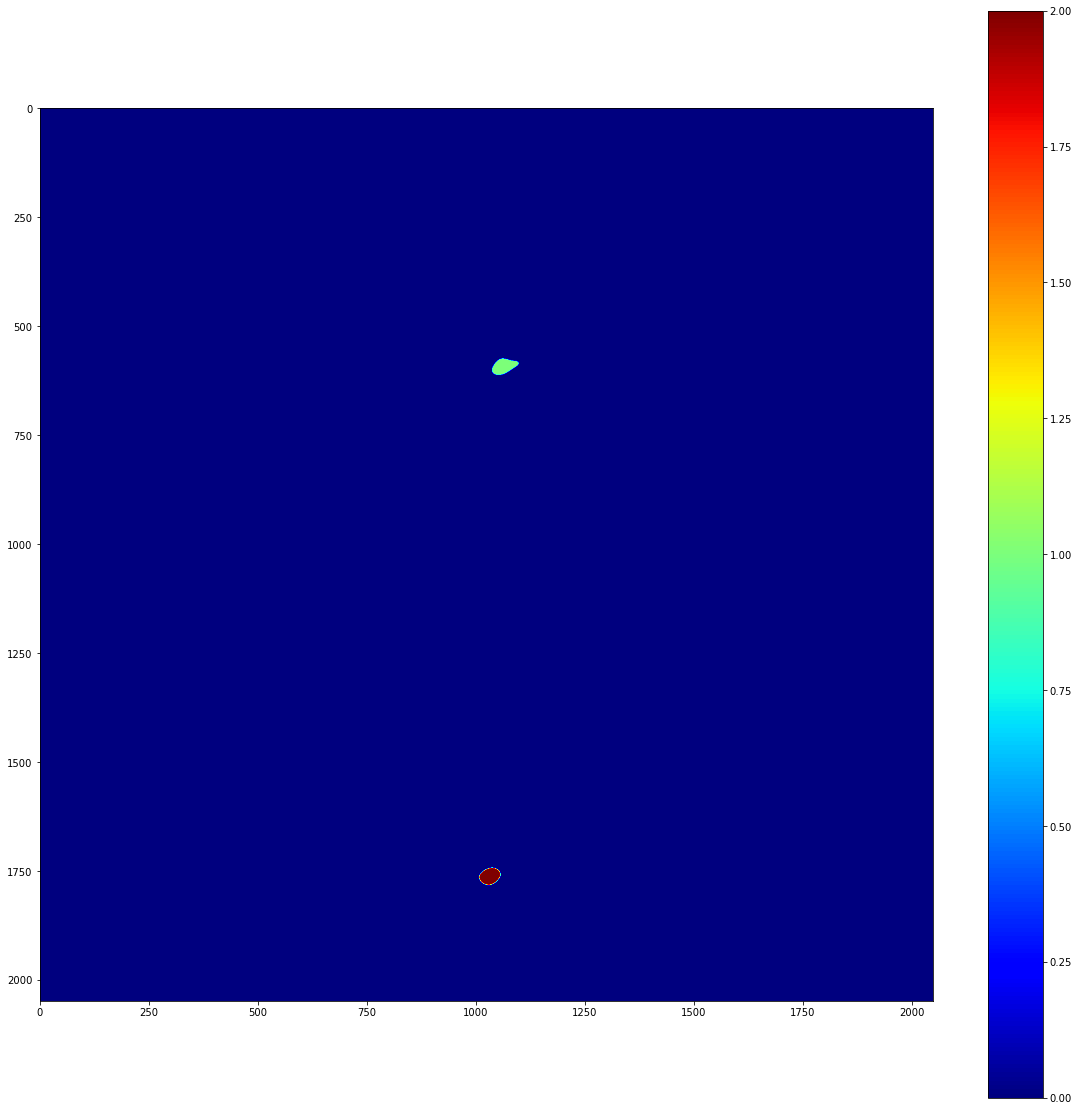

In [9]:
cluster_img = np.zeros_like(image.image_array)
for i, cluster in enumerate(clusters):
    pixels_x, pixels_y = cluster.pixel_indices
    cluster_img[pixels_y, pixels_x] = i+1

plot_imshow(cluster_img)

So, we have two separate clusters, and we can freely access the pixels that are
contained within each cluster. We can also apply a list of clusters as a mask
to an image. This can produce images with _perfect background subtraction_. To
demonstrate this, lets take a look at the background subtracted image that we
prepared earlier.

/var/folders/91/cjqffvc108ddp27nm67npc000000gn/T/ipykernel_74661/4036432486.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


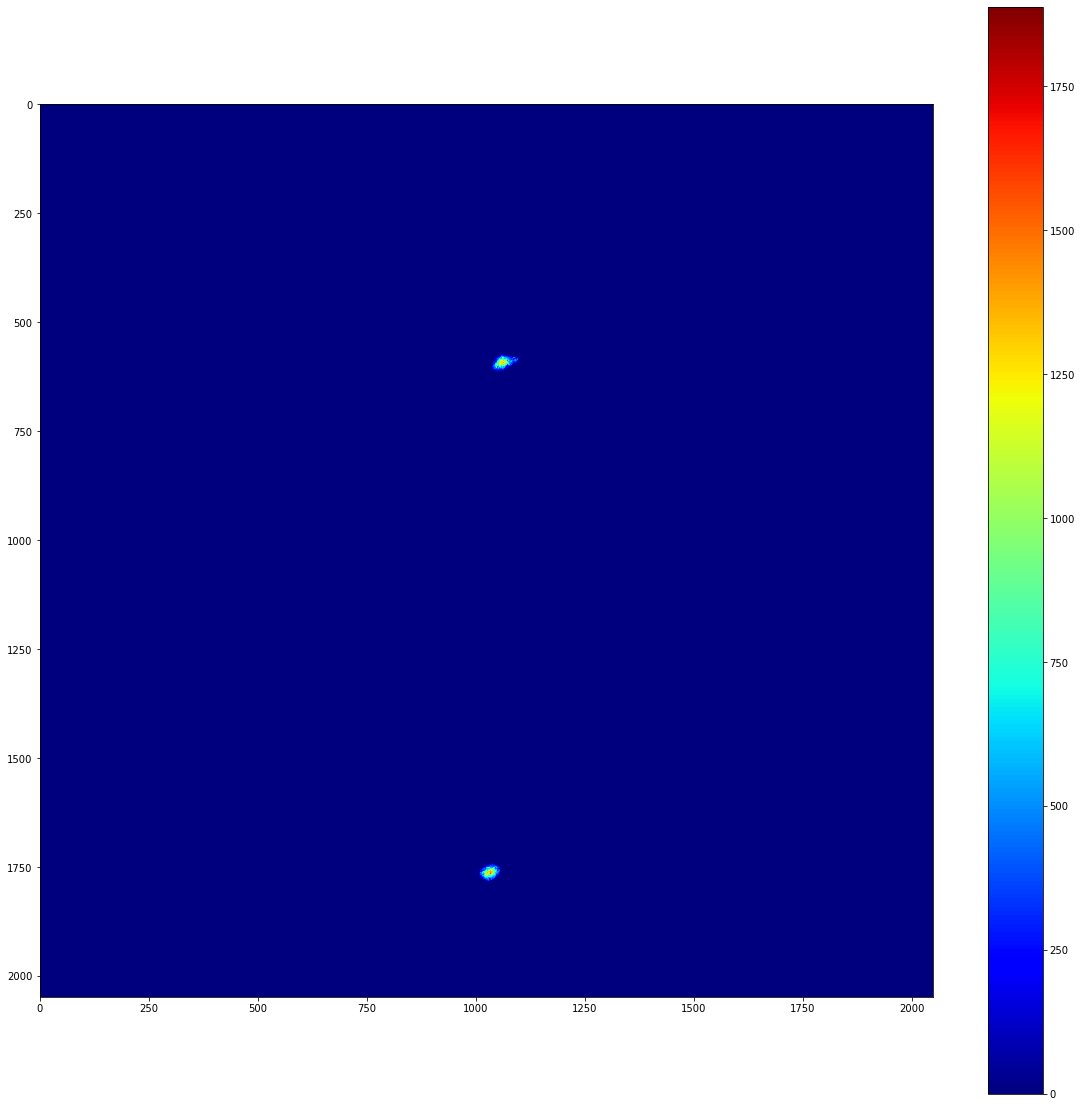

In [10]:
cluster_mask = image.mask_from_clusters(clusters)

signal_in_clusters = cluster_mask*bkg_subtracted_image_array
plot_imshow(signal_in_clusters)

If you know the position of the beam centre and the pixel size, it's possible
to map this image into reciprocal space. Using
[PyFAI](https://pyfai.readthedocs.io/en/master/index.html) as a backend, this
can be done in a performant and reproducible way. local_stats' io module
provides a convenient way to construct the .poni file that PyFAI depends on.

In [11]:
from local_stats.io import write_poni

# If this isn't written in your log book in a transmission experiment, you did
# bad science! These are in units of pixels, counting from the top left.
beam_centre_x = 1045
beam_centre_y = 1175

poni_path = "my_little.poni"
# Ask your favourite beamline scientist for these if you don't know them. Both
# in units of metre.
pixel_size = 13.5e-6
detector_distance = 0.474
# You should definitely know this, though.
wavelength = 1.7e-9 

write_poni(poni_path, pixel_size, detector_distance, beam_centre_x,
           beam_centre_y, wavelength)



Now we're able to use the PyFAI package's fast azimuthal integration routines
to measure, for example, our scattering Q. The PyFAI package is capable of far
more than this, see https://pyfai.readthedocs.io/en/master/index.html.

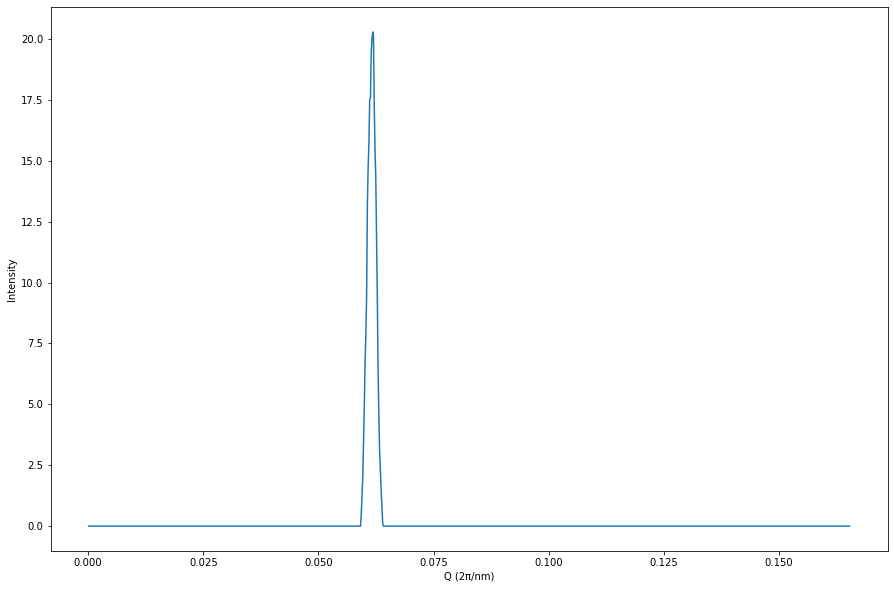

In [12]:
import pyFAI

# The number of azimuthal integrals to carry out.
n_integrals = 1000

fai = pyFAI.load(poni_path)
result = fai.integrate1d(signal_in_clusters, n_integrals)

plt.figure(figsize=(15, 10))
plt.xlabel("Q (2π/nm)")
plt.ylabel("Intensity")
plt.plot(result[0], result[1]);
